# Apply Signature Analysis to Cell Morphology Features

Gregory Way, 2020

Here, I apply [`singscore`](https://bioconductor.org/packages/devel/bioc/vignettes/singscore/inst/doc/singscore.html) ([Foroutan et al. 2018](https://doi.org/10.1186/s12859-018-2435-4)) to our Cell Painting profiles.
This notebook largely follows the [package vignette](https://bioconductor.org/packages/devel/bioc/vignettes/singscore/inst/doc/singscore.html).

I generate two distinct signatures.

1. Comparing Clone A and E resistant clones to sensitive wildtype cell lines.
   * Clones A and E both have a confirmed _PSMB5_ mutation which is known to cause bortezomib resistance.
2. Derived from comparing four other resistant clones to four other sensitive wildtype clones.
   * We do not know the resistance mechanism in these four resistant clones.

However, we can hypothesize that the mechanisms are similar based on single sample enrichment using the potential PSMB5 signature.

To review how I derived these signatures see `0.build-morphology-signatures.ipynb`.

In [1]:
suppressPackageStartupMessages(library(singscore))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))

In [2]:
seed <- 1234
num_permutations <- 1000

In [3]:
set.seed(seed)

## Load Clone A/E (_PSMB5_ Mutations) Signature

In [4]:
sig_cols <- readr::cols(
  feature = readr::col_character(),
  estimate = readr::col_double(),
  adj.p.value = readr::col_double()
)

sig_file <- file.path("results", "cloneAE_signature_tukey.tsv")
psmb_signature_scores <- readr::read_tsv(sig_file, col_types=sig_cols)

head(psmb_signature_scores, 2)

term,comparison,estimate,conf.low,conf.high,adj.p.value,feature,neg_log_p
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
Metadata_clone_type,wildtype-resistant,-2.118107,-2.465917,-1.770297,3.128045e-09,Nuclei_AreaShape_Zernike_6_0,8.504727
Metadata_clone_type,wildtype-resistant,-1.375233,-1.614782,-1.135684,6.727405e-09,Cytoplasm_Granularity_3_Mito,8.172152


In [5]:
# Extract features that are up and down in the signature
up_features <- psmb_signature_scores %>% dplyr::filter(estimate > 0) %>% dplyr::pull(feature)
down_features <- psmb_signature_scores %>% dplyr::filter(estimate < 0) %>% dplyr::pull(feature)

## Load Four Clone Dataset

In [6]:
col_types <- readr::cols(
    .default = readr::col_double(),
    Metadata_Plate = readr::col_character(),
    Metadata_Well = readr::col_character(),
    Metadata_plate_map_name = readr::col_character(),
    Metadata_clone_number = readr::col_character(),
    Metadata_clone_type = readr::col_character(),
    Metadata_plate_ID = readr::col_character(),
    Metadata_plate_filename = readr::col_character(),
    Metadata_treatment = readr::col_character(),
    Metadata_batch = readr::col_character()
)

# Do not load the feature selected data
profile_dir <- file.path("..", "2.describe-data", "data", "merged")
profile_file <- file.path(profile_dir, "combined_four_clone_dataset.csv")

fourclone_data_df <- readr::read_csv(profile_file, col_types = col_types)

print(dim(fourclone_data_df))
head(fourclone_data_df, 2)

[1]  300 3537


Metadata_Plate,Metadata_Well,Metadata_batch,Metadata_clone_number,Metadata_plate_ID,Metadata_plate_filename,Metadata_plate_map_name,Metadata_treatment,Metadata_clone_type,Cells_AreaShape_Area,⋯,Nuclei_Texture_Variance_RNA_10_02,Nuclei_Texture_Variance_RNA_10_03,Nuclei_Texture_Variance_RNA_20_00,Nuclei_Texture_Variance_RNA_20_01,Nuclei_Texture_Variance_RNA_20_02,Nuclei_Texture_Variance_RNA_20_03,Nuclei_Texture_Variance_RNA_5_00,Nuclei_Texture_Variance_RNA_5_01,Nuclei_Texture_Variance_RNA_5_02,Nuclei_Texture_Variance_RNA_5_03
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
217760,B02,2019_11_20_Batch6,BZ017,217760,20191120-20191115-HiDensity,217760,DMSO,resistant,-0.4099156,⋯,1.0335199,1.00769977,0.9201253,0.8701705,0.9247584,0.88671667,1.0062414,1.0097513,1.0152607,1.0312612
217760,B03,2019_11_20_Batch6,WT002,217760,20191120-20191115-HiDensity,217760,DMSO,wildtype,-0.1376312,⋯,0.1422616,0.09471271,0.1560825,0.0389161,0.1352465,-0.04278426,0.1076544,0.1256983,0.1154676,0.1365938


In [7]:
# Generate unique sample names (for downstream merging of results)
sample_names <- paste(
    fourclone_data_df$Metadata_clone_number,
    fourclone_data_df$Metadata_Plate,
    fourclone_data_df$Metadata_Well,
    fourclone_data_df$Metadata_batch,
    sep = "_"
)

fourclone_data_df <- fourclone_data_df %>%
    dplyr::mutate(Metadata_unique_sample_name = sample_names)

## Apply `singscore`

In [8]:
# Convert the four clone dataset into a feature x sample matrix without metadata
features_only_df <- t(fourclone_data_df %>% dplyr::select(!starts_with("Metadata_")))

# Apply the `rankGenes()` method to get feature rankings per feature for each sample
rankData <- rankGenes(features_only_df)
colnames(rankData) <- fourclone_data_df$Metadata_unique_sample_name

print(dim(rankData))
head(rankData, 3)

[1] 3528  300


,BZ017_217760_B02_2019_11_20_Batch6,WT002_217760_B03_2019_11_20_Batch6,WT008_217760_B04_2019_11_20_Batch6,WT009_217760_B05_2019_11_20_Batch6,BZ018_217760_B06_2019_11_20_Batch6,WT011_217760_B07_2019_11_20_Batch6,BZ001_217760_B08_2019_11_20_Batch6,BZ008_217760_B09_2019_11_20_Batch6,WT_parental_217760_B10_2019_11_20_Batch6,WT_parental_217760_B11_2019_11_20_Batch6,⋯,WT_parental_217766_G02_2019_11_22_Batch7,BZ017_217766_G03_2019_11_22_Batch7,WT002_217766_G04_2019_11_22_Batch7,WT008_217766_G05_2019_11_22_Batch7,WT009_217766_G06_2019_11_22_Batch7,BZ018_217766_G07_2019_11_22_Batch7,WT_parental_217766_G08_2019_11_22_Batch7,WT011_217766_G09_2019_11_22_Batch7,BZ001_217766_G10_2019_11_22_Batch7,BZ008_217766_G11_2019_11_22_Batch7
Cells_AreaShape_Area,1317,1928,929,3056,245,3247,2337,2309,1581,1745,⋯,3031,635,1846,392,2724,1665,3468,3426,2403,2490
Cells_AreaShape_Center_X,1612,1499,2494,2424,1265,1015,890,177,3485,3398,⋯,1376,3330,2502,2073,3512,2649,1466,303,3224,3473
Cells_AreaShape_Center_Y,1163,1094,144,670,3,214,1230,103,1163,2038,⋯,2172,3498,2010,2418,3256,2909,2996,3110,3502,3354


In [9]:
# Using the rank dataframe, up, and down features, get the sample scores
scoredf <- simpleScore(rankData, upSet = up_features, downSet = down_features)

# Merge scores with metadata features
full_result_df <- dplyr::bind_cols(
    fourclone_data_df %>% dplyr::select(starts_with("Metadata_")),
    scoredf
    )

print(dim(full_result_df))
head(full_result_df, 2)

[1] 300  16


Metadata_Plate,Metadata_Well,Metadata_batch,Metadata_clone_number,Metadata_plate_ID,Metadata_plate_filename,Metadata_plate_map_name,Metadata_treatment,Metadata_clone_type,Metadata_unique_sample_name,TotalScore,TotalDispersion,UpScore,UpDispersion,DownScore,DownDispersion
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
217760,B02,2019_11_20_Batch6,BZ017,217760,20191120-20191115-HiDensity,217760,DMSO,resistant,BZ017_217760_B02_2019_11_20_Batch6,0.2719791,1881.419,0.08703072,1319.5140,0.18494838,561.9054
217760,B03,2019_11_20_Batch6,WT002,217760,20191120-20191115-HiDensity,217760,DMSO,wildtype,WT002_217760_B03_2019_11_20_Batch6,0.1611450,1624.188,0.11566174,645.6723,0.04548325,978.5160


## Perform Permutation Testing to Determine Significance of Observation

In [10]:
# Generate a null distribution of scores by randomly shuffling ranks
permuteResult <- generateNull(
    upSet = up_features,
    downSet = down_features, 
    rankData = rankData,
    centerScore = TRUE,
    knownDirection = TRUE,
    B = num_permutations,
    seed = seed,
    useBPPARAM = NULL
)

# Calculate p values and add to list
pvals <- getPvals(permuteResult, scoredf)
pval_tidy <- broom::tidy(pvals)
colnames(pval_tidy) <- c("names", "Metadata_permuted_p_value")

full_result_df <- full_result_df %>%
    dplyr::left_join(
        pval_tidy,
        by = c("Metadata_unique_sample_name" = "names")
    )

Warning message:
“'tidy.numeric' is deprecated.
See help("Deprecated")”

In [11]:
# Are there differences in quantiles across batch?
batch_info <- gsub("^.*_", "", rownames(t(permuteResult)))
batch_permute <- t(permuteResult) %>%
    dplyr::as_tibble() %>%
    dplyr::mutate(batch = batch_info)

permute_bounds <- list()
for (batch_id in unique(batch_permute$batch)) {
    subset_permute <- batch_permute %>% dplyr::filter(batch == !!batch_id) %>% dplyr::select(!batch)
    min_val <- quantile(as.vector(as.matrix(subset_permute)), 0.005)
    max_val <- quantile(as.vector(as.matrix(subset_permute)), 0.995)
    permute_bounds[[batch_id]] <- c(batch_id, min_val, max_val)
}

do.call(rbind, permute_bounds)

Warning message:
“`as_tibble.matrix()` requires a matrix with column names or a `.name_repair` argument. Using compatibility `.name_repair`.
This warning is displayed once per session.”

,,0.5%,99.5%
Batch6,Batch6,-0.324864565091039,0.322436592653803
Batch5,Batch5,-0.328372312135821,0.321825360921959
Batch7,Batch7,-0.325685491475228,0.325733526699634


## Visualize Results

In [12]:
min_val <- quantile(as.vector(as.matrix(permuteResult)), 0.05)
max_val <- quantile(as.vector(as.matrix(permuteResult)), 0.95)

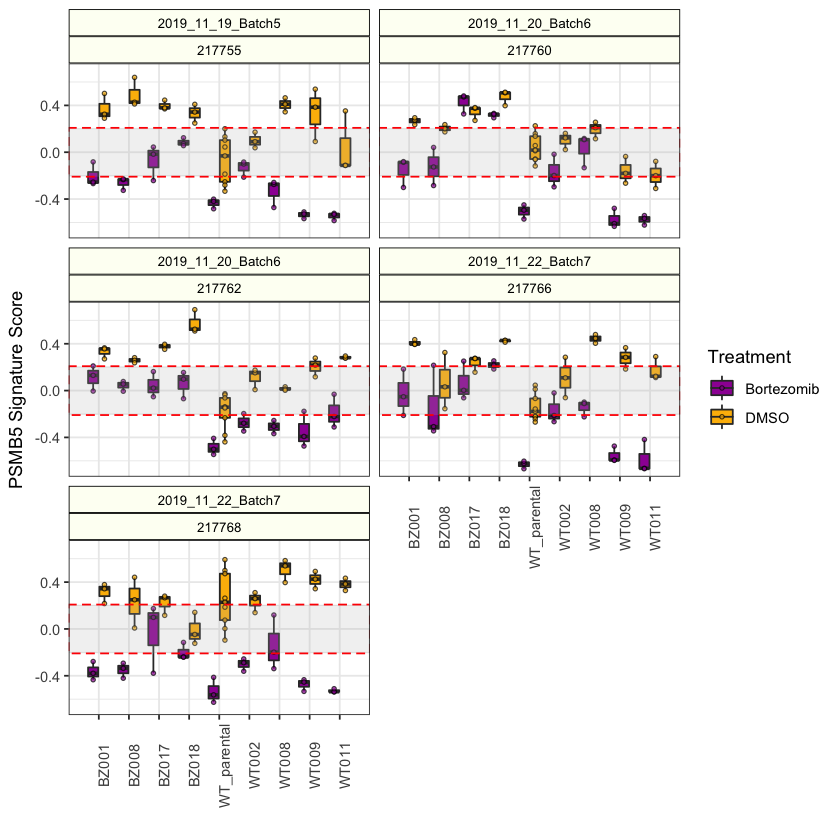

In [13]:
apply_psmb_signature_gg <- ggplot(full_result_df,
       aes(y = TotalScore,
           x = Metadata_clone_number)) +
    geom_boxplot(aes(fill = Metadata_treatment), outlier.alpha = 0) +
    geom_point(
        aes(fill = Metadata_treatment, group = Metadata_treatment),
        position = position_dodge(width=0.75),
        size = 0.9,
        alpha = 0.7,
        shape = 21) +
    scale_fill_manual(name = "Treatment",
                      labels = c("bortezomib" = "Bortezomib", "DMSO" = "DMSO"),
                      values = c("bortezomib" = "#9e0ba3", "DMSO" = "#fcba03")) +
    theme_bw() +
    annotate("rect", ymin = min_val,
              ymax = max_val,
              xmin = 0,
              xmax = length(unique(full_result_df$Metadata_clone_number)) + 1,
              alpha = 0.2,
              color = "red",
              linetype = "dashed",
              fill = "grey") +
    xlab("") +
    ylab("PSMB5 Signature Score") +
    theme(axis.text.x = element_text(angle=90)) +
    facet_wrap("Metadata_batch~Metadata_plate_ID", nrow=3) +
    theme(strip.text = element_text(size = 8, color = "black"),
          strip.background = element_rect(colour = "black", fill = "#fdfff4"))

output_fig <- file.path("figures", "signature", "psmb5_signature_apply_fourclone.png")
ggsave(output_fig, dpi = 500, height = 5, width = 10)
apply_psmb_signature_gg

In [14]:
summarized_mean_result_df <- full_result_df %>%
    dplyr::group_by(
        Metadata_batch, Metadata_plate_map_name, Metadata_clone_number, Metadata_treatment, Metadata_clone_type
    ) %>%
    dplyr::mutate(mean_score = mean(TotalScore)) %>%
    dplyr::select(
        Metadata_batch, Metadata_plate_map_name, Metadata_clone_number, Metadata_clone_type, Metadata_treatment, mean_score
    ) %>%
    dplyr::distinct() %>%
    tidyr::spread(key = "Metadata_treatment", value = "mean_score") %>%
    dplyr::mutate(treatment_score_diff = DMSO - bortezomib)

head(summarized_mean_result_df)

Metadata_batch,Metadata_plate_map_name,Metadata_clone_number,Metadata_clone_type,bortezomib,DMSO,treatment_score_diff
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
2019_11_19_Batch5,217755,BZ001,resistant,-0.20177418,0.37252051,0.5742947
2019_11_19_Batch5,217755,BZ008,resistant,-0.26249734,0.49293094,0.7554283
2019_11_19_Batch5,217755,BZ017,resistant,-0.07163731,0.39816353,0.4698008
2019_11_19_Batch5,217755,BZ018,resistant,0.08440856,0.33365843,0.2492499
2019_11_19_Batch5,217755,WT_parental,wildtype,-0.43472425,-0.06711094,0.3676133
2019_11_19_Batch5,217755,WT002,wildtype,-0.13252596,0.10012284,0.2326488


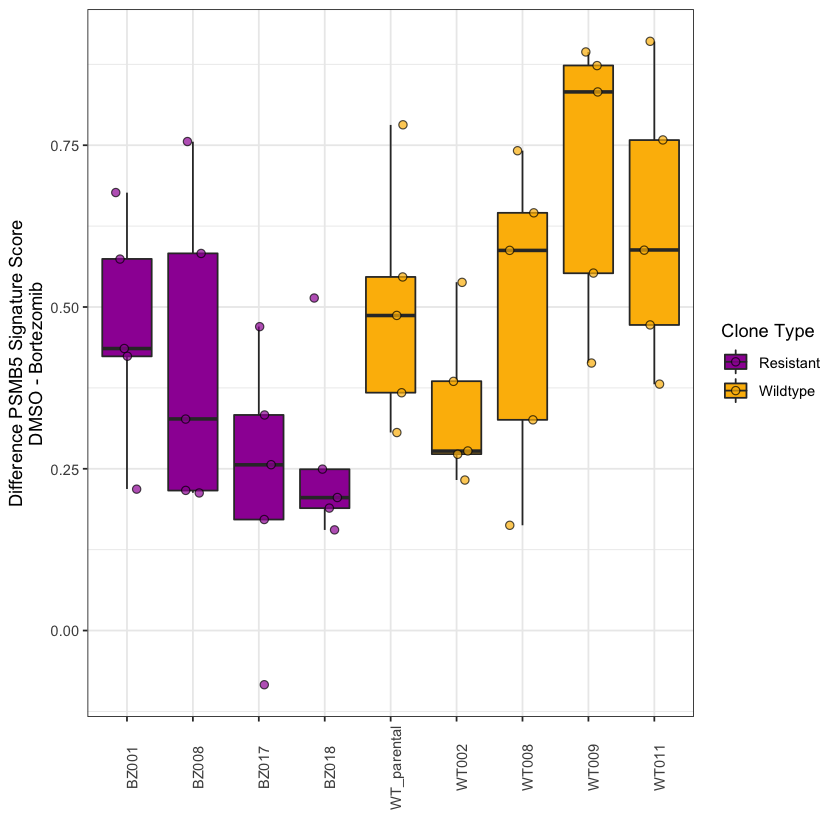

In [15]:
apply_psmb_signature_diff_gg <- ggplot(summarized_mean_result_df,
       aes(y = treatment_score_diff,
           x = Metadata_clone_number,
           fill = Metadata_clone_type)) +
    geom_boxplot(outlier.alpha = 0) +
    geom_jitter(
        width = 0.2,
        size = 2,
        alpha = 0.7,
        shape = 21) +

    scale_fill_manual(name = "Clone Type",
                      labels = c("resistant" = "Resistant", "wildtype" = "Wildtype"),
                      values = c("resistant" = "#9e0ba3", "wildtype" = "#fcba03")) +
    theme_bw() +
    xlab("") +
    ylab("Difference PSMB5 Signature Score\nDMSO - Bortezomib") +
    theme(axis.text.x = element_text(angle=90)) +
    theme(strip.text = element_text(size = 8, color = "black"),
          strip.background = element_rect(colour = "black", fill = "#fdfff4"))

output_fig <- file.path("figures", "signature", "psmb5_signature_apply_fourclone_difference.png")
ggsave(output_fig, dpi = 500, height = 4.5, width = 6)

apply_psmb_signature_diff_gg

## Load Four Clone Signature (Generic Resistance)

In [16]:
sig_file <- file.path("results", "fourclone_signature_tukey.tsv")
resistance_signature_scores <- readr::read_tsv(sig_file, col_types=sig_cols)

head(resistance_signature_scores, 2)

term,comparison,estimate,conf.low,conf.high,adj.p.value,feature,neg_log_p
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
Metadata_clone_type,wildtype-resistant,-1.526815,-1.739565,-1.314065,0,Nuclei_RadialDistribution_RadialCV_Mito_2of4,Inf
Metadata_clone_type,wildtype-resistant,-1.408145,-1.643285,-1.173005,0,Nuclei_RadialDistribution_RadialCV_ER_1of4,Inf


In [17]:
# Extract features that are up and down in the signature
up_resistance_features <- resistance_signature_scores %>%
    dplyr::filter(estimate > 0) %>%
    dplyr::pull(feature)

down_resistance_features <- resistance_signature_scores %>%
    dplyr::filter(estimate < 0) %>%
    dplyr::pull(feature)

## Load Clone A/E Dataset

In [18]:
# Do not load the feature selected data
profile_file <- file.path(profile_dir, "combined_cloneAcloneE_dataset.csv")

cloneae_cols <- readr::cols(
  .default = readr::col_double(),
  Metadata_CellLine = readr::col_character(),
  Metadata_Plate = readr::col_character(),
  Metadata_Well = readr::col_character(),
  Metadata_batch = readr::col_character(),
  Metadata_plate_map_name = readr::col_character(),
  Metadata_clone_type = readr::col_character()
)


cloneAE_data_df <- readr::read_csv(profile_file, col_types = cloneae_cols)

print(dim(cloneAE_data_df))
head(cloneAE_data_df, 2)

[1]   72 3535


Metadata_CellLine,Metadata_Dosage,Metadata_Plate,Metadata_Well,Metadata_batch,Metadata_plate_map_name,Metadata_clone_type,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,⋯,Nuclei_Texture_Variance_RNA_10_02,Nuclei_Texture_Variance_RNA_10_03,Nuclei_Texture_Variance_RNA_20_00,Nuclei_Texture_Variance_RNA_20_01,Nuclei_Texture_Variance_RNA_20_02,Nuclei_Texture_Variance_RNA_20_03,Nuclei_Texture_Variance_RNA_5_00,Nuclei_Texture_Variance_RNA_5_01,Nuclei_Texture_Variance_RNA_5_02,Nuclei_Texture_Variance_RNA_5_03
<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
WT,0,207106_exposure320,B02,2019_03_20_Batch2,PlateMap_207106_exposure320,wildtype,-0.2399697,0.7740968,0.9813073,⋯,-0.4609553,-0.4715662,-0.4729019,-0.4639081,-0.4913005,-0.4916511,-0.4651303,-0.4637457,-0.4589179,-0.4615954
WT,0,207106_exposure320,B03,2019_03_20_Batch2,PlateMap_207106_exposure320,wildtype,-0.3247018,-1.7047238,0.7933065,⋯,-0.4076935,-0.4098359,-0.4187497,-0.4005857,-0.4317288,-0.4351959,-0.4077395,-0.4082742,-0.4048926,-0.4032867


In [19]:
# Generate unique sample names (for downstream merging of results)
cloneae_sample_names <- paste(
    cloneAE_data_df$Metadata_CellLine,
    cloneAE_data_df$Metadata_Plate,
    cloneAE_data_df$Metadata_Well,
    cloneAE_data_df$Metadata_batch,
    sep = "_"
)

cloneAE_data_df <- cloneAE_data_df %>%
    dplyr::mutate(Metadata_unique_sample_name = cloneae_sample_names)

## Apply `singscore`

In [20]:
# Convert the four clone dataset into a feature x sample matrix without metadata
features_only_res_df <- t(cloneAE_data_df %>% dplyr::select(!starts_with("Metadata_")))

# Apply the `rankGenes()` method to get feature rankings per feature for each sample
rankData_res <- rankGenes(features_only_res_df)
colnames(rankData_res) <- cloneAE_data_df$Metadata_unique_sample_name

print(dim(rankData_res))
head(rankData_res, 3)

[1] 3528   72


,WT_207106_exposure320_B02_2019_03_20_Batch2,WT_207106_exposure320_B03_2019_03_20_Batch2,WT_207106_exposure320_B04_2019_03_20_Batch2,CloneA_207106_exposure320_B05_2019_03_20_Batch2,CloneA_207106_exposure320_B06_2019_03_20_Batch2,CloneA_207106_exposure320_B07_2019_03_20_Batch2,CloneE_207106_exposure320_B08_2019_03_20_Batch2,CloneE_207106_exposure320_B09_2019_03_20_Batch2,CloneE_207106_exposure320_B10_2019_03_20_Batch2,WT_207106_exposure320_C02_2019_03_20_Batch2,⋯,CloneE_HCT116bortezomib_D11_2019_02_15_Batch1_20X,WT_HCT116bortezomib_E03_2019_02_15_Batch1_20X,WT_HCT116bortezomib_E04_2019_02_15_Batch1_20X,WT_HCT116bortezomib_E05_2019_02_15_Batch1_20X,CloneA_HCT116bortezomib_E06_2019_02_15_Batch1_20X,CloneA_HCT116bortezomib_E07_2019_02_15_Batch1_20X,CloneA_HCT116bortezomib_E08_2019_02_15_Batch1_20X,CloneE_HCT116bortezomib_E09_2019_02_15_Batch1_20X,CloneE_HCT116bortezomib_E10_2019_02_15_Batch1_20X,CloneE_HCT116bortezomib_E11_2019_02_15_Batch1_20X
Cells_AreaShape_Area,1599,1329,1430,70,785,1582,1796,1226,2902,1425,⋯,3515,906,827,959,2252,2885,2696,1530,1453,1898
Cells_AreaShape_Center_X,2981,16,3170,2705,2120,1271,963,2087,35,656,⋯,2224,1021,590,83,672,1951,1491,1452,1136,2776
Cells_AreaShape_Center_Y,3112,3056,3098,2005,1725,1326,1396,2935,2376,5,⋯,3356,3029,2061,1225,1344,2274,3314,793,110,677


In [21]:
# Using the rank dataframe, up, and down features, get the sample scores
scoredf_res <- simpleScore(rankData_res,
                           upSet = up_resistance_features,
                           downSet = down_resistance_features)

# Merge scores with metadata features
full_res_result_df <- dplyr::bind_cols(
    cloneAE_data_df %>% dplyr::select(starts_with("Metadata_")),
    scoredf_res
    )

print(dim(full_res_result_df))
head(full_res_result_df, 2)

[1] 72 14


Metadata_CellLine,Metadata_Dosage,Metadata_Plate,Metadata_Well,Metadata_batch,Metadata_plate_map_name,Metadata_clone_type,Metadata_unique_sample_name,TotalScore,TotalDispersion,UpScore,UpDispersion,DownScore,DownDispersion
<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
WT,0,207106_exposure320,B02,2019_03_20_Batch2,PlateMap_207106_exposure320,wildtype,WT_207106_exposure320_B02_2019_03_20_Batch2,0.3162650,1558.213,0.1543636,558.9402,0.1619014,999.2724
WT,0,207106_exposure320,B03,2019_03_20_Batch2,PlateMap_207106_exposure320,wildtype,WT_207106_exposure320_B03_2019_03_20_Batch2,0.3082661,1932.569,0.1724623,616.0203,0.1358039,1316.5488


## Perform Permutation Testing

In [22]:
# Generate a null distribution of scores by randomly shuffling ranks
permuteResult_res <- generateNull(
    upSet = up_resistance_features,
    downSet = down_resistance_features, 
    rankData = rankData_res,
    centerScore = TRUE,
    knownDirection = TRUE,
    B = num_permutations,
    seed = seed,
    useBPPARAM = NULL
)

# Calculate p values and add to list
pvals_res <- getPvals(permuteResult_res, scoredf_res)
pval_res_tidy <- broom::tidy(pvals)
colnames(pval_res_tidy) <- c("names", "Metadata_permuted_p_value")

full_res_result_df <- full_res_result_df %>%
    dplyr::left_join(
        pval_res_tidy,
        by = c("Metadata_unique_sample_name" = "names")
    )

Warning message:
“'tidy.numeric' is deprecated.
See help("Deprecated")”

## Visualize Signature Results

In [23]:
min_val <- quantile(as.vector(as.matrix(permuteResult_res)), 0.05)
max_val <- quantile(as.vector(as.matrix(permuteResult_res)), 0.95)

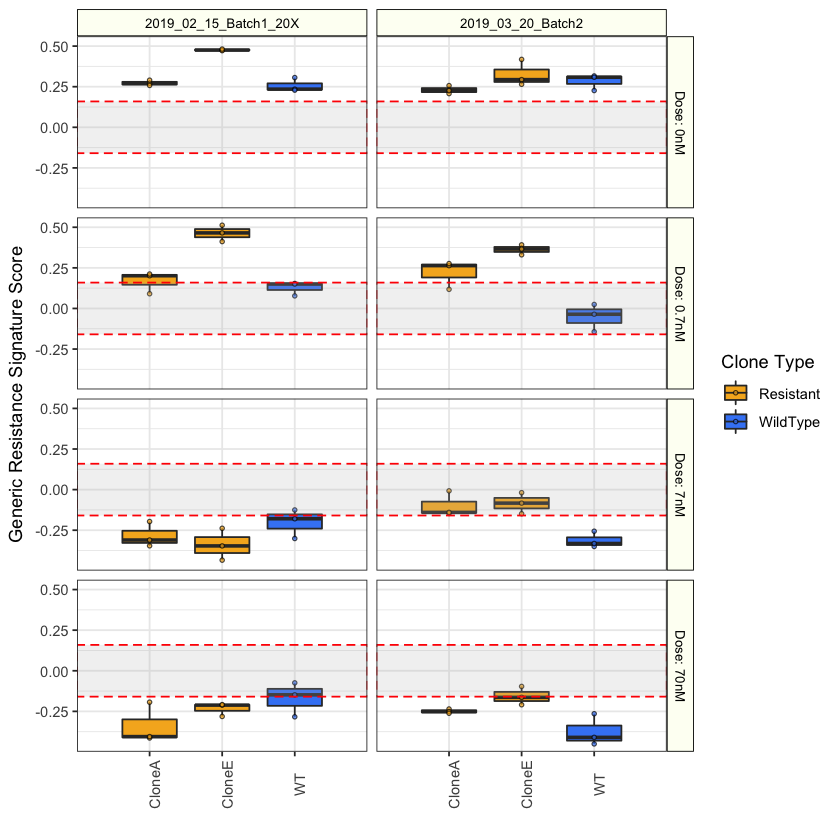

In [24]:
append_dose <- function(string) paste0("Dose: ", string, "nM")

apply_res_signature_gg <- ggplot(full_res_result_df,
       aes(y = TotalScore,
           x = Metadata_CellLine)) +
    geom_boxplot(aes(fill = Metadata_clone_type), outlier.alpha = 0) +
    geom_point(
        aes(fill = Metadata_clone_type, group = Metadata_clone_type),
        position = position_dodge(width=0.75),
        size = 0.9,
        alpha = 0.7,
        shape = 21) +
    scale_fill_manual(name = "Clone Type",
                      labels = c("resistant" = "Resistant", "wildtype" = "WildType"),
                      values = c("resistant" = "#f5b222", "wildtype" = "#4287f5")) +
    theme_bw() +
    annotate("rect", ymin = min_val,
                  ymax = max_val,
                  xmin = 0,
                  xmax = length(unique(full_res_result_df$Metadata_CellLine)) + 1,
                  alpha = 0.2,
                  color = "red",
                  linetype = "dashed",
                  fill = "grey") +
    xlab("") +
    ylab("Generic Resistance Signature Score") +
    theme(axis.text.x = element_text(angle=90)) +
    facet_grid("Metadata_Dosage~Metadata_batch",
               labeller = labeller(Metadata_Dosage = as_labeller(append_dose))) +
    theme(strip.text = element_text(size = 8, color = "black"),
          strip.background = element_rect(colour = "black", fill = "#fdfff4"))


output_fig <- file.path("figures", "signature", "generic_resistance_signature_apply_cloneAE.png")
ggsave(output_fig, dpi = 500, height = 5, width = 5)
apply_res_signature_gg

In [25]:
full_res_result_df$Metadata_Dosage <- factor(
    full_res_result_df$Metadata_Dosage, levels = unique(sort(full_res_result_df$Metadata_Dosage))
)
full_res_result_df <- full_res_result_df %>%
    dplyr::mutate(Metadata_group = paste0(Metadata_batch, Metadata_CellLine))

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 0.985”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 2.015”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  4.2401e-17”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 4.0602”Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
“pseudoinverse used at 0.985”Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
“neighborhood radius 2.015”Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) objec

“pseudoinverse used at 0.985”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 2.015”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  4.2401e-17”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 4.0602”Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
“pseudoinverse used at 0.985”Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
“neighborhood radius 2.015”Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)),

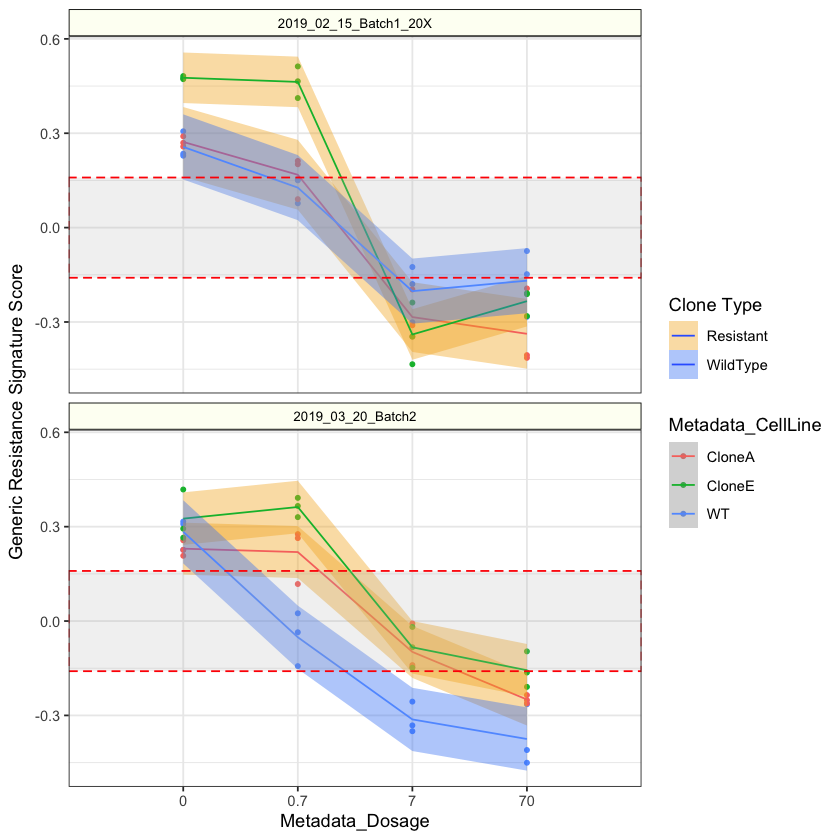

In [26]:
ggplot(full_res_result_df, aes(x = Metadata_Dosage, y = TotalScore, color = Metadata_CellLine, group = Metadata_group)) +
    geom_point(size = 1) +
    geom_smooth(aes(fill = Metadata_clone_type), method = "loess", lwd = 0.5) +
    facet_wrap("~Metadata_batch", nrow = 2) +
    theme_bw() +
    scale_fill_manual(name = "Clone Type",
                          labels = c("resistant" = "Resistant", "wildtype" = "WildType"),
                          values = c("resistant" = "#f5b222", "wildtype" = "#4287f5")) +
    ylab("Generic Resistance Signature Score") +
    annotate("rect", ymin = min_val,
                      ymax = max_val,
                      xmin = 0,
                      xmax = length(unique(full_res_result_df$Metadata_CellLine)) + 2,
                      alpha = 0.2,
                      color = "red",
                      linetype = "dashed",
                      fill = "grey") +
    theme(strip.text = element_text(size = 8, color = "black"),
          strip.background = element_rect(colour = "black", fill = "#fdfff4"))

output_fig <- file.path("figures", "signature", "generic_resistance_signature_apply_cloneAE_xaxis_dosage.png")
ggsave(output_fig, dpi = 500, height = 5, width = 5)